In [1]:
#CORA RAW on standard depth level - October 2021
import datetime as dt
import glob
import netCDF4 as nc
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import cmocean
import gsw

from gsw import sigma0
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
cartopy.config["data_dir"] = './cartopy_shapefiles'

from skfda.representation.basis import BSpline, Fourier, Monomial, FDataBasis
from skfda.representation.grid import FDataGrid

os.getcwd()

'/home1/datahome/epauthen/All_depth'

# Interpolate each profiles on a regular vertical grid (All of that is done on the script interp_cora.py)
- Interpolate each profiles with np.interp() dwon to 4000m

In [61]:
pi = np.concatenate([[0, 1, 2, 3, 4, 5, 6, 8, 10, 12, 14, 16, 19, 22, 26, 30, 35, 40, 45, 50, 55, 60, 
                      65, 70, 75, 80, 90, 100, 110, 120, 133, 147, 163, 180, 199, 221, 245, 271, 301, 334, 371, 412]
                     ,np.arange(450,4050,50)])
#plt.scatter(pi,([1] * len(pi)))
len(pi)
#Change sign of z

114

In [62]:
%%time
listfile = glob.glob('/home/datawork-lops-bluecloud/osnet/data_cora_raw/raw_all_depth/*.nc')
total_files = len(listfile)
datasets = []
nb_prof = 0
count = 0

CPU times: user 56 ms, sys: 4 ms, total: 60 ms
Wall time: 57.9 ms


In [63]:
for myfile in listfile:
    ds = xr.open_dataset(myfile)
    ds = ds.dropna('N_PROF', how = "all", subset=['TEMP', 'PSAL'])
    N = len(ds.N_PROF)
    #Exclude empty files
    if N>0:
        TEMPi = np.empty((N,len(pi)))
        TEMPi[:] = np.nan
        PSALi = np.empty((N,len(pi)))
        PSALi[:] = np.nan
        TEMPs = np.empty((N,len(pi)))
        TEMPs[:] = np.nan
        PSALs = np.empty((N,len(pi)))
        PSALs[:] = np.nan
        z = -gsw.z_from_p(ds.PRES, ds.LAT)
        ds = ds.assign(variables={"DEPTH": (('N_PROF','N_PRES'), z.data)})
        for n in range(0,N):
            idx_interp = np.argwhere(~np.isnan(ds.PRES.isel(N_PROF=n).data)).reshape(-1)
            if len(idx_interp)>1:
                TEMPi[n,:] = np.interp(pi, ds.DEPTH[n,idx_interp], ds.TEMP[n,idx_interp], right=np.nan)
                PSALi[n,:] = np.interp(pi, ds.DEPTH[n,idx_interp], ds.PSAL[n,idx_interp], right=np.nan)
                TEMPs[n,:] = np.interp(pi, ds.DEPTH[n,idx_interp], ds.TEMP[n,idx_interp], left=np.nan, right=np.nan)
                PSALs[n,:] = np.interp(pi, ds.DEPTH[n,idx_interp], ds.PSAL[n,idx_interp], left=np.nan, right=np.nan)
            #EXPORT INTERPOLATED PROFILES
        dsi = xr.Dataset(
            data_vars=dict(
                TEMP_SURF = (["N_PROF","DEPTH"], TEMPs),
                PSAL_SURF = (["N_PROF","DEPTH"], PSALs),
                TEMP_INTERP = (["N_PROF","DEPTH"], TEMPi),
                PSAL_INTERP = (["N_PROF","DEPTH"], PSALi),
                DC_REFERENCE    = (["N_PROF"], ds.DC_REFERENCE.data),
                PLATFORM_NUMBER = (["N_PROF"], ds.PLATFORM_NUMBER.data)),
            coords=dict(
                LON  = (["N_PROF"], ds.LON.data),
                LAT  = (["N_PROF"], ds.LAT.data),
                DEPTH  = (["DEPTH"], pi),
                JULD = (["N_PROF"],ds.JULD.data)))
        datasets.append(dsi)
        nb_prof = nb_prof + len(dsi.N_PROF)
    count = count+1
    if count % 1000 == 0:
        print(f"{(np.around((count/total_files)*100,1))}% done")
        print(f"{nb_prof} profiles processed")

print('finished, concatenation starting')
ds_interp = xr.concat(datasets, dim='N_PROF')

In [64]:
ds_interp.to_netcdf("/home/datawork-lops-bluecloud/osnet/data_cora_raw/CORA_all_depth_interp.nc")

In [2]:
#Verif
ds = xr.open_dataset("/home/datawork-lops-bluecloud/osnet/data_cora_raw/CORA_all_depth_interp.nc")
ds

<xarray.Dataset>
Dimensions:          (N_PROF: 273708, DEPTH: 114)
Coordinates:
    LON              (N_PROF) float64 ...
    LAT              (N_PROF) float64 ...
  * DEPTH            (DEPTH) int64 0 1 2 3 4 5 ... 3750 3800 3850 3900 3950 4000
    JULD             (N_PROF) datetime64[ns] ...
Dimensions without coordinates: N_PROF
Data variables:
    TEMP_SURF        (N_PROF, DEPTH) float64 ...
    PSAL_SURF        (N_PROF, DEPTH) float64 ...
    TEMP_INTERP      (N_PROF, DEPTH) float64 ...
    PSAL_INTERP      (N_PROF, DEPTH) float64 ...
    DC_REFERENCE     (N_PROF) |S8 ...
    PLATFORM_NUMBER  (N_PROF) |S8 ...

(4000.0, 0.0)

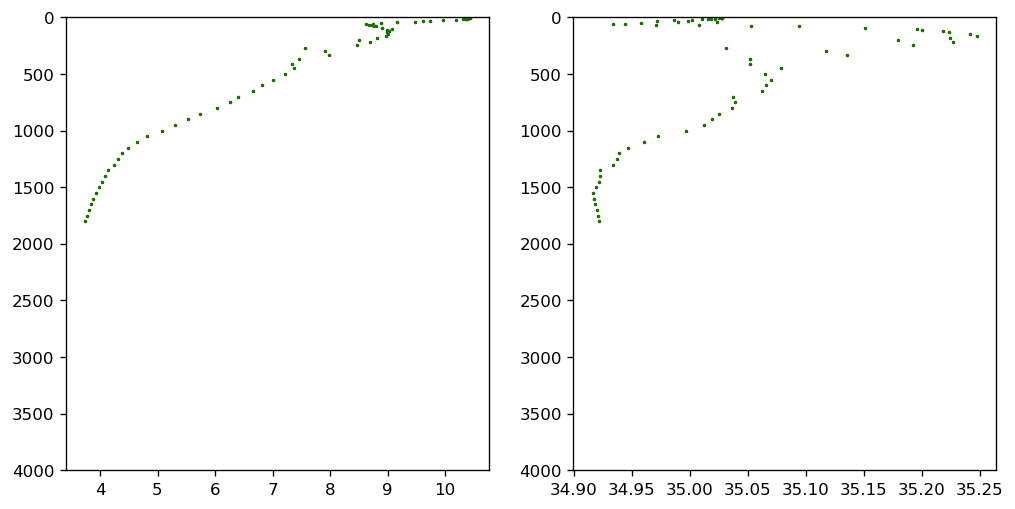

In [8]:
n = 15
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5), dpi=120, facecolor='w', edgecolor='k')
ax[0].scatter(ds.TEMP_INTERP[n,:],ds.DEPTH, s = 1,c = 'red')
ax[0].scatter(ds.TEMP_SURF[n,:],ds.DEPTH, s = 1,c = 'green')
ax[0].set_ylim([4000,0])

ax[1].scatter(ds.PSAL_INTERP[n,:],ds.DEPTH, s = 1,c = 'red')
ax[1].scatter(ds.PSAL_SURF[n,:],ds.DEPTH, s = 1,c = 'green')
ax[1].set_ylim([4000,0])

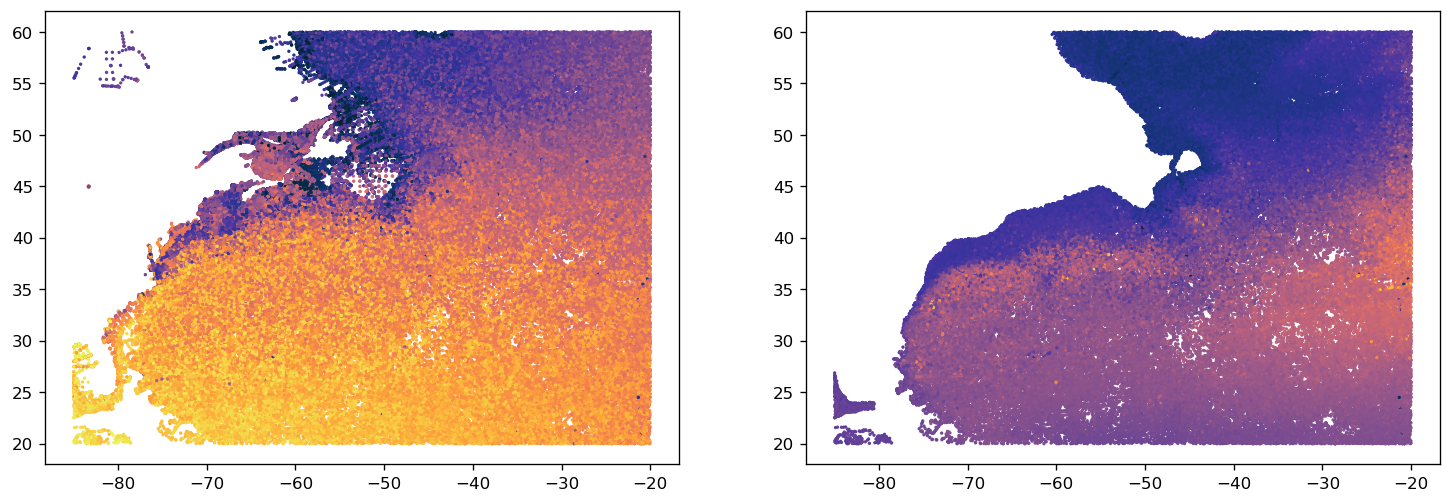

In [5]:
#Map
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5), dpi=120, facecolor='w', edgecolor='k')
ax[0].scatter(ds.LON,ds.LAT,s = 1,c = ds.TEMP_INTERP.sel(DEPTH = 0),cmap = cmocean.cm.thermal)
ax[1].scatter(ds.LON,ds.LAT,s = 1,c = ds.TEMP_INTERP.sel(DEPTH = 1000),cmap = cmocean.cm.thermal)

plt.show()